In [1]:
#import packages internal and external
import tests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import pandas as pd
import datasetBuilder
import tools
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.base
import pickle
import copy
import tests
from sklearn.metrics import roc_auc_score as auc
import os
import plotAndOrderResults

In [2]:
#Set path variables where we want to save created datasets, intermediate outputs, etc
#If you want to run this on your own computer, obviously you should update the path
outputs_path='/Users/jonahpoczobutt/projects/specsim_res/figOutputs'


nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_lc.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_experimental.pkl'

#Set the query and target dbs
#these can be different or the same
query = metlin
target = nist14

#This variable toggles whether we do a full run of the notebook, or if we read in variables created in a previous run
fullRun=True

#create directories for results
if fullRun:
    
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/fig1')
    os.mkdir(f'{outputs_path}/fig1/fig1a')
    os.mkdir(f'{outputs_path}/fig1/supplementary')
    os.mkdir(f'{outputs_path}/fig1/fig1b')
    os.mkdir(f'{outputs_path}/fig2')


Preprocessing: Creating Target and Matches DFs


In [3]:
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    first_bases = all_bases[:int(len(all_bases)/2)]
    second_bases = all_bases[int(len(all_bases)/2):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/second_query.pkl')
    del(second_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/second_bases.npy',second_bases)
    del(first_bases)
    del(second_bases)


In [13]:
from collections import Counter
res = pd.read_pickle('/Users/jonahpoczobutt/projects/specsim_res/figOutputs/fig1/supplementary/matches_5_ppm.pkl')

res=res[res['match']==False]

np.std(res['prec_abs_dif'])

0.00019463725943177915

Figure 1a: Global Performance of Individual Metrics/Weighting Schemes

In [4]:
#these are the ppm windows that we want to test
ppm_windows = [5,10]

#this is the size of the sample we take from the full target
size=5e5

#this is the maximum number of matches we allow for each query, based on the precursor window
max_matches=100

#adduct match
adduct_match=True

#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05,0.1]
centroid_tolerance_vals = [0.05, 3]
centroid_tolerance_types=['da','ppm']
powers=[0.25,1,3,'ent',None]
sim_methods=None

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload queries and target for individual comparison
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    #shuffle query to ensure random subset
    query_.sample(frac=1)

    for i in ppm_windows:

        matches = datasetBuilder.create_matches_df_new(query_,target_,i,max_matches,size, adduct_match)
        matches.to_pickle(f'{outputs_path}/fig1/supplementary/matches_{i}_ppm.pkl')

        #comparison on large sample
        tests.create_variable_comparisons(
                                noise_threshes=noise_threshes,
                                centroid_threshes=centroid_tolerance_vals,
                                centroid_types=centroid_tolerance_types,
                                powers=powers,
                                sim_methods=sim_methods,
                                matches=matches,
                                outpath = f'{outputs_path}/fig1/fig1a/{i}_ppm.csv',
                                )

KeyboardInterrupt: 

Figure 1b: Assessing Metric Stability in Smaller Samples

In [17]:
#this is the size of the sample we take from the full target
size=5e3

#this is the number of times we want to take a sample of the above size
trials=1

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload target
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    for i in range(trials):

        os.mkdir(f'{outputs_path}/fig1/fig1b/{i}')
        
        for j in ppm_windows:

            #create matches after shuffling query
            query_ = query_.sample(frac=1)
            matches = datasetBuilder.create_matches_df_new(query_,target_,j,max_matches,size, adduct_match)

            #comparison on small sample
            tests.create_variable_comparisons(
                                    noise_threshes=noise_threshes,
                                    centroid_threshes=centroid_tolerance_vals,
                                    centroid_types=centroid_tolerance_types,
                                    powers=powers,
                                    sim_methods=sim_methods,
                                    matches=matches,
                                    outpath = f'{outputs_path}/fig1/fig1b/{i}/{j}_ppm.csv'
                                    )

KeyboardInterrupt: 

Figures 1a and 1b

Top Metrics for 5_ppm.csv by AUC
       0                      1         2                3
869   53  symmetric_chi_squared  0.899254   0.01_3_ppm_ent
563   53  symmetric_chi_squared  0.896974  0.01_3_ppm_0.25
971   53  symmetric_chi_squared  0.894489  0.01_3_ppm_None
1603  73              minkowski  0.861281  0.05_3_ppm_0.25
590   80         mean_character  0.859375  0.01_3_ppm_0.25
896   80         mean_character  0.858218   0.01_3_ppm_ent
998   80         mean_character  0.850320  0.01_3_ppm_None
2011  73              minkowski  0.847052  0.05_3_ppm_None
583   73              minkowski  0.845316  0.01_3_ppm_0.25
2623  73              minkowski  0.821487   0.1_3_ppm_0.25




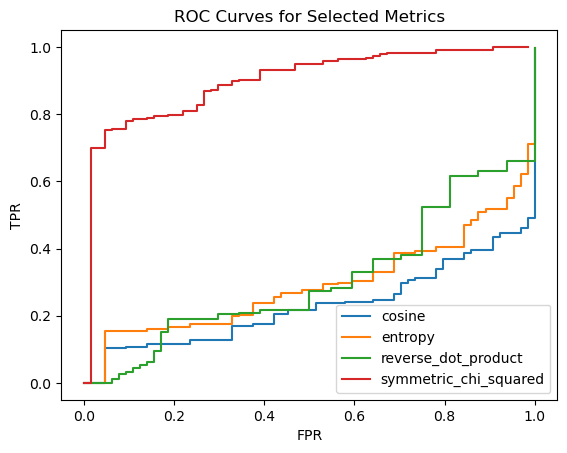

Top Metrics for 10_ppm.csv by AUC
       0                      1         2                3
869   53  symmetric_chi_squared  0.899254   0.01_3_ppm_ent
563   53  symmetric_chi_squared  0.896974  0.01_3_ppm_0.25
971   53  symmetric_chi_squared  0.894489  0.01_3_ppm_None
1603  73              minkowski  0.861281  0.05_3_ppm_0.25
590   80         mean_character  0.859375  0.01_3_ppm_0.25
896   80         mean_character  0.858218   0.01_3_ppm_ent
998   80         mean_character  0.850320  0.01_3_ppm_None
2011  73              minkowski  0.847052  0.05_3_ppm_None
583   73              minkowski  0.845316  0.01_3_ppm_0.25
2623  73              minkowski  0.821487   0.1_3_ppm_0.25




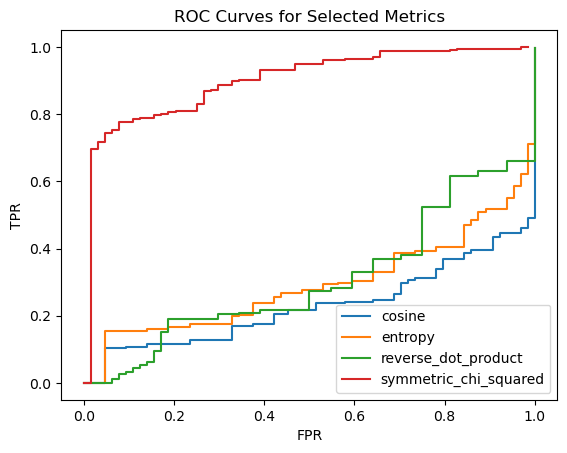

In [ ]:
#first, generate tables from full size
plotAndOrderResults.fig1a(f'{outputs_path}/fig1/fig1a','/Users/jonahpoczobutt/projects/specsim_res/figOutputs/fig1/supplementary')


In [ ]:
#assess metric stability from small runs
plotAndOrderResults.fig1b(f'{outputs_path}/fig1/fig1b', ppm_windows)

Top Ranks and Means for 5 PPM
Percent Time This Metric is Top
                            index    0
0             improved_similarity  0.5
1  whittaker_index_of_association  0.5


Mean Ranking By Metric
                            index    0
0             improved_similarity  4.0
6  whittaker_index_of_association  4.0


Top Ranks and Means for 10 PPM
Percent Time This Metric is Top
                                index    0
0                          lorentzian  0.5
1  max_whittaker_index_of_association  0.5


Mean Ranking By Metric
                                 index     0
0                           lorentzian   2.5
96  max_whittaker_index_of_association  49.0




In [10]:
#figure 1
#column 3 is noise clip, peak consolidation value and type, weighting
#none weighting is the original weighted entropy scheme from the paper
ppm3 = pd.read_csv('/Users/jonahpoczobutt/projects/specsim_res/individual_sims/matches_3_ppm.csv', header=None)
ppm3.sort_values(by=2, ascending=False, inplace=True)

ppm5 = pd.read_csv('/Users/jonahpoczobutt/projects/specsim_res/individual_sims/matches_5_ppm.csv', header=None)
ppm5.sort_values(by=2, ascending=False, inplace=True)

ppm10 = pd.read_csv('/Users/jonahpoczobutt/projects/specsim_res/individual_sims/matches_10_ppm.csv', header=None)
ppm10.sort_values(by=2, ascending=False, inplace=True)

ppm15 = pd.read_csv('/Users/jonahpoczobutt/projects/specsim_res/individual_sims/matches_15_ppm.csv', header=None)
ppm15.sort_values(by=2, ascending=False, inplace=True)